In [1]:
import json 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open('Cell_Phones_and_Accessories_5.json', 'r') as file:
    data = [json.loads(line) for line in file]

norm_data = pd.json_normalize(data)
df = pd.DataFrame(norm_data)
df.head()

reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...      4.0   
1  These stickers work like the review says they ...      5.0   
2  These are awesome and make my phone look so st...      5.0   
3  Item arrived in great time and was in perfect ...      4.0   
4  awesome! stays on, and looks great. can be use...      5.0   

                                     summary  unixReviewTime   reviewTime  
0                                 Looks Good      1400630400  05 21, 2014  
1                      Really great product.      1389657600  01 14, 2014  
2                             LOVE LOVE LOVE      1403740800  06 26, 2014  
3                                      Cute!      1382313600  10 21, 2013  
4  leopard home button sticker for iphone 4s      1359849600   02 3, 2013

In [3]:
print(f"{df.shape[0]} reviews")
print(f"{df["asin"].nunique()} unique products")
print(f"{df['reviewerID'].nunique()} unique reviewers")

194439 reviews
10429 unique products
27879 unique reviewers


In [4]:
print(f"Minimum reviews for a single product: {df["asin"].value_counts()[-1]}")
print(f"Minimum reviews from a single user: {df["reviewerID"].value_counts()[-1]}")

Minimum reviews for a single product: 5
Minimum reviews from a single user: 5


C:\Users\darth\AppData\Local\Temp\ipykernel_23832\4191937166.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Minimum reviews for a single product: {df["asin"].value_counts()[-1]}")
C:\Users\darth\AppData\Local\Temp\ipykernel_23832\4191937166.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Minimum reviews from a single user: {df["reviewerID"].value_counts()[-1]}")


We can see here that the dataset has only considered reviewers with a minimum of 5 reviews written, and products with a minimum of 5 reviews recieved. The below cell shows all the reviews submitted by user "A4N8QJCW9EY1A"

In [5]:
print(df.loc[df["reviewerID"] == "A4N8QJCW9EY1A"] ["reviewText"])

186013    I don't use apple products, so when someone wi...
190481    Adoption of the USB standard for chargers has ...
193880    I use my laptop or desktop to charge most devi...
194066    My truck already has three 12 volt sockets (on...
194099    After using this for about a week, I can't thi...
Name: reviewText, dtype: object


My next goal will be to get 100 reviews of a specific product and identify key aspects that are commonly mentioned in reviews. I will use product "B005SUHPO6" since it is the most reviewed in the dataset. 

In [6]:
df_filtered = df[df["asin"] == "B005SUHPO6"][:100].reset_index()
df_filtered_reviews = df_filtered["reviewText"]
df_filtered_reviews
for i in range(10):
    print(df_filtered_reviews[i])

excellent product at 1/2 the price as sale at electronic store, wow fit perfect on my iphone
Sometimes the flap over the charging place is hard to stay locked in, I have to keep trying and trying to lock it in there, it drives me crazy!!!!  I love the  colors that I bought, the blue one I have not used yet, maybe next year.  I like a change once in awhile......other than the locking in flap, I am happy with them.
Great case.  Fits like every other Otterbox Defender case I have own.  It does a great job of protecting your phone from drops onto the ground.  I feel that the Defender case is a bit bulky sometimes, but the holster is a major plus for my dad.
Use these for our technicians and anyone that is hard on a phone.  In a business environment you need a touch case to avoid costly repairs.
It's very strong and protects my 4S phone! I think this was a great value! I will buy another one in a newer color!
you know what. It has three layers, and for what? It does protect your phone again

Looking at this paragraph these ten topics seem to be frequently mentioned: ["price", "drop protection", "fit", "aesthetics", "durability", "weight", "ease of use", "quality", "dust protection", "slimness"]. Time to run the zero-shot classification to find the main topic of each review.

In [7]:
aspects = ["price", "protection", "fit", "aesthetics", "durability", "weight", "ease of use", "quality", "repurchase intent", "bulkyness"]
review_list = df_filtered_reviews.tolist()

from transformers import pipeline

pipe = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
score_table = pipe(review_list,
    candidate_labels=aspects,
    multi_label=True
)

c:\Users\darth\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


In [8]:
score_table = pd.DataFrame(score_table)
score_table = score_table.explode(["labels", "scores"])
score_table = score_table.pivot_table(index="sequence",
                                 columns="labels",
                                 values="scores",
                                 aggfunc="mean")
score_table

labels                                             aesthetics bulkyness  \
sequence                                                                  
A great phone case wow I dropped my phone so ma...   0.009285  0.065796   
A must have to protect your iphone.  I will say...   0.000639  0.961681   
After two years, I needed to replace my Otterbo...   0.111634  0.277408   
Bulky and annoying but does what it's supposed ...   0.007374  0.993055   
Did a nice job. Makes my son's I-phone secure, ...   0.928329  0.002078   
...                                                       ...       ...   
purchased as a gift loved it and a great buy to...   0.001163  0.002481   
this case offers great protection for your ipho...   0.001854  0.894602   
this is a great case, fits the phone nicely, an...   0.562407  0.265927   
very good protection but is quite bulky  recomm...   0.001621  0.980874   
you know what. It has three layers, and for wha...   0.043534  0.871273   

labels                                             durability ease of use  \
sequence                                                                    
A great phone case wow I dropped my phone so ma...   0.962288    0.350595   
A must have to protect your iphone.  I will say...   0.573857    0.002765   
After two years, I needed to replace my Otterbo...   0.965296    0.411888   
Bulky and annoying but does what it's supposed ...   0.692297    0.004467   
Did a nice job. Makes my son's I-phone secure, ...   0.837292    0.891422   
...                                                       ...         ...   
purchased as a gift loved it and a great buy to...   0.825439    0.587903   
this case offers great protection for your ipho...   0.704803    0.003802   
this is a great case, fits the phone nicely, an...   0.913793    0.937386   
very good protection but is quite bulky  recomm...   0.820835    0.000454   
you know what. It has three layers, and for wha...   0.431776    0.180297   

labels                                                   fit     price  \
sequence                                                                 
A great phone case wow I dropped my phone so ma...  0.908043   0.24034   
A must have to protect your iphone.  I will say...  0.822356  0.109718   
After two years, I needed to replace my Otterbo...    0.8817  0.384208   
Bulky and annoying but does what it's supposed ...  0.395219  0.232568   
Did a nice job. Makes my son's I-phone secure, ...  0.991482  0.122335   
...                                                      ...       ...   
purchased as a gift loved it and a great buy to...  0.989355  0.836659   
this case offers great protection for your ipho...  0.894257  0.650736   
this is a great case, fits the phone nicely, an...   0.99797  0.955626   
very good protection but is quite bulky  recomm...  0.711978  0.056476   
you know what. It has three layers, and for wha...  0.906185  0.315599   

labels                                             protection   quality  \
sequence                                                                  
A great phone case wow I dropped my phone so ma...   0.930523  0.988705   
A must have to protect your iphone.  I will say...   0.985115  0.939447   
After two years, I needed to replace my Otterbo...   0.975193  0.985828   
Bulky and annoying but does what it's supposed ...   0.985395  0.332564   
Did a nice job. Makes my son's I-phone secure, ...   0.962089  0.997653   
...                                                       ...       ...   
purchased as a gift loved it and a great buy to...   0.992389  0.997733   
this case offers great protection for your ipho...   0.959885  0.969876   
this is a great case, fits the phone nicely, an...   0.996008  0.999126   
very good protection but is quite bulky  recomm...   0.971678  0.977169   
you know what. It has three layers, and for wha...   0.916381  0.615086   

labels                                             repurchase intent    weight  
se

In [9]:
for col in score_table.columns:
    score_table[col] = pd.to_numeric(score_table[col], errors="coerce")
score_table["main topic"] = score_table.idxmax(axis=1, numeric_only=True)


Now we have a table with scores for each topic, for each review. We have also noted down with topic scored highest for each review, lets see how often each topic "won", and what the distribution of the scores were for the main topics.

In [10]:
score_table

labels                                              aesthetics  bulkyness  \
sequence                                                                    
A great phone case wow I dropped my phone so ma...    0.009285   0.065796   
A must have to protect your iphone.  I will say...    0.000639   0.961681   
After two years, I needed to replace my Otterbo...    0.111634   0.277408   
Bulky and annoying but does what it's supposed ...    0.007374   0.993055   
Did a nice job. Makes my son's I-phone secure, ...    0.928329   0.002078   
...                                                        ...        ...   
purchased as a gift loved it and a great buy to...    0.001163   0.002481   
this case offers great protection for your ipho...    0.001854   0.894602   
this is a great case, fits the phone nicely, an...    0.562407   0.265927   
very good protection but is quite bulky  recomm...    0.001621   0.980874   
you know what. It has three layers, and for wha...    0.043534   0.871273   

labels                                              durability  ease of use  \
sequence                                                                      
A great phone case wow I dropped my phone so ma...    0.962288     0.350595   
A must have to protect your iphone.  I will say...    0.573857     0.002765   
After two years, I needed to replace my Otterbo...    0.965296     0.411888   
Bulky and annoying but does what it's supposed ...    0.692297     0.004467   
Did a nice job. Makes my son's I-phone secure, ...    0.837292     0.891422   
...                                                        ...          ...   
purchased as a gift loved it and a great buy to...    0.825439     0.587903   
this case offers great protection for your ipho...    0.704803     0.003802   
this is a great case, fits the phone nicely, an...    0.913793     0.937386   
very good protection but is quite bulky  recomm...    0.820835     0.000454   
you know what. It has three layers, and for wha...    0.431776     0.180297   

labels                                                   fit     price  \
sequence                                                                 
A great phone case wow I dropped my phone so ma...  0.908043  0.240340   
A must have to protect your iphone.  I will say...  0.822356  0.109718   
After two years, I needed to replace my Otterbo...  0.881700  0.384208   
Bulky and annoying but does what it's supposed ...  0.395219  0.232568   
Did a nice job. Makes my son's I-phone secure, ...  0.991482  0.122335   
...                                                      ...       ...   
purchased as a gift loved it and a great buy to...  0.989355  0.836659   
this case offers great protection for your ipho...  0.894257  0.650736   
this is a great case, fits the phone nicely, an...  0.997970  0.955626   
very good protection but is quite bulky  recomm...  0.711978  0.056476   
you know what. It has three layers, and for wha...  0.906185  0.315599   

labels                                              protection   quality  \
sequence                                                                   
A great phone case wow I dropped my phone so ma...    0.930523  0.988705   
A must have to protect your iphone.  I will say...    0.985115  0.939447   
After two years, I needed to replace my Otterbo...    0.975193  0.985828   
Bulky and annoying but does what it's supposed ...    0.985395  0.332564   
Did a nice job. Makes my son's I-phone secure, ...    0.962089  0.997653   
...                                                        ...       ...   
purchased as a gift loved it and a great buy to...    0.992389  0.997733   
this case offers great protection for your ipho...    0.959885  0.969876   
this is a great case, fits the phone nicely, an...    0.996008  0.999126   
very good protection but is quite bulky  recomm...    0.971678  0.977169   
you know what. It has three layers, and for wha...    0.916381  0.615086   

labels            

In [11]:
topics_df=pd.DataFrame(score_table.columns.drop("main topic"))
topics_df.rename(columns={"labels" : "main topic"}, inplace=True)
freq_df = pd.DataFrame(score_table["main topic"].value_counts()).reset_index()
freq_df = topics_df.merge(freq_df, on="main topic", how="left")
freq_df["count"] = freq_df["count"].fillna(0).astype(int)

C:\Users\darth\AppData\Local\Temp\ipykernel_23832\4109146960.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.barplot(data = freq_df,
C:\Users\darth\AppData\Local\Temp\ipykernel_23832\4109146960.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bp.set_xticklabels(labels = freq_df["main topic"],


[Text(0.5, 0, 'Topic'), Text(0, 0.5, 'Frequency as the Main Topic')]

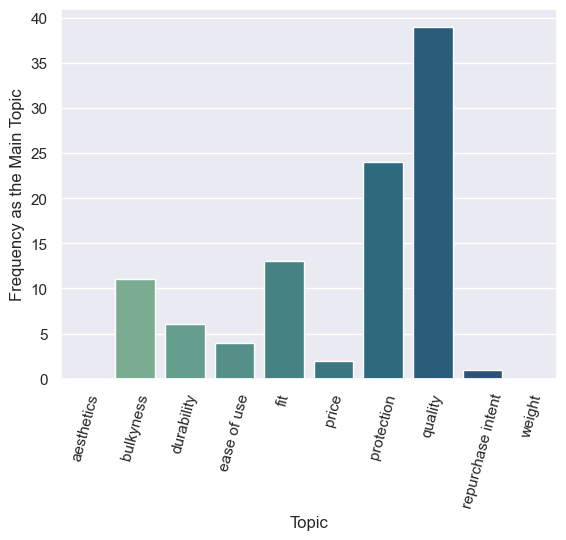

In [12]:
# Produce a bar chart to show frequency of each topic as the main topic
sns.set_theme()
bp = sns.barplot(data = freq_df,
            x="main topic",
            y="count",
            palette="crest",
            )
bp.set_xticklabels(labels = freq_df["main topic"],
                   rotation = 75)
bp.set(xlabel="Topic", ylabel="Frequency as the Main Topic")

C:\Users\darth\AppData\Local\Temp\ipykernel_23832\2948153635.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  kde = sns.kdeplot(data=main_topic_scores, palette="crest")


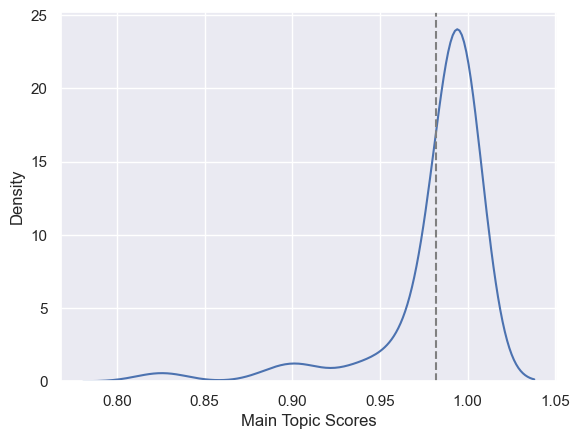

Average main topic score: 0.98


In [13]:
#Create main topic score column
column_indexer = score_table.columns.get_indexer(score_table["main topic"])
column_indexer
main_topic_scores = score_table.values[np.arange(len(score_table)), column_indexer]
main_topic_scores
kde = sns.kdeplot(data=main_topic_scores, palette="crest")
kde.set(xlabel="Main Topic Scores")
plt.axvline(x=np.mean(main_topic_scores), color='grey', linestyle='--')
plt.show()
print(f"Average main topic score: {round(np.mean(main_topic_scores), ndigits=2)}")

We see that aesthetics and weight are not chosen as the main aspect once, suggesting these are not good labels and we should change them. The average score for a main topic is 0.98, suggesting the zero-shot classifier is confident in its predictions. Now it's time to start implementing some sentiment analysis.

In [14]:
import torch
print(torch.__version__)

2.8.0+cu126


In [15]:
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
sentiment = sentiment_analysis(review_list)


Device set to use cuda:0


In [16]:
sentiment_df = pd.DataFrame(sentiment).rename(columns={"label":"aspect sentiment", "score":"sentiment score"})
score_table = score_table.reset_index().join(sentiment_df)

In [17]:
score_table.loc[score_table["aspect sentiment"] == "NEGATIVE"]

sequence  aesthetics  bulkyness  \
5   Don't get me wrong, this is a great case, and ...    0.662402   0.296476   
13  Great case.  Fits like every other Otterbox De...    0.014512   0.872795   
14  I Bought this Outter Box for my Godson and he ...    0.128599   0.119065   
22  I bought this case for my boss' Iphone 4s. It ...    0.033183   0.054566   
31  I got this case for my partner when she switch...    0.097293   0.061079   
48  Lobe the otterbox case it has saved my iphone ...    0.016620   0.291433   
57  Not much to say.  It's a hard case with screen...    0.646140   0.981486   
76  This is a tough case! It stands up well to wha...    0.015352   0.045629   
78  This is one heck of a phone case. We stuck my ...    0.100679   0.972415   
80  This phone case was purchased for my wife's ne...    0.861305   0.097736   
85  Very great case for my Iphone 4, like some oth...    0.074487   0.004528   

    durability  ease of use       fit     price  protection   quality  \
5     0.839036     0.923478  0.926208  0.889343    0.958665  0.934145   
13    0.859947     0.082063  0.978900  0.109082    0.983929  0.993548   
14    0.883368     0.803589  0.980204  0.426866    0.987218  0.983855   
22    0.998055     0.598647  0.995821  0.282247    0.995031  0.997299   
31    0.996336     0.990544  0.992761  0.515595    0.990042  0.998625   
48    0.969128     0.477569  0.958483  0.175245    0.995769  0.993453   
57    0.737208     0.028643  0.830483  0.212703    0.990868  0.794088   
76    0.996786     0.000499  0.989095  0.234492    0.592675  0.973244   
78    0.988393     0.994359  0.992409  0.611413    0.997037  0.998334   
80    0.987282     0.834644  0.986881  0.942501    0.968432  0.986819   
85    0.567346     0.426926  0.967278  0.015429    0.932253  0.993094   

    repurchase intent    weight  main topic aspect sentiment  sentiment score  
5            0.362551  0.465868  protection         NEGATIVE         0.999511  
13           0.034987  0.672952     quality         NEGATIVE         0.999500  
14           0.338450  0.218340  protection         NEGATIVE         0.999508  
22           0.170328  0.669650  durability         NEGATIVE         0.999504  
31           0.163908  0.855674     quality         NEGATIVE         0.999474  
48           0.070434  0.105769  protection         NEGATIVE         0.999497  
57           0.288592  0.932884  protection         NEGATIVE         0.999501  
76           0.302843  0.092058  durability         NEGATIVE         0.999510  
78           0.310715  0.981327     quality         NEGATIVE         0.999507  
80           0.349569  0.632832  durability         NEGATIVE         0.999503  
85           0.042093  0.071406     quality         NEGATIVE         0.999504

These reviews with 0.999 negative scores have sentences in them praising certain aspects of the product, this is has been missed by the analysis! To correct this I plan on splitting the reviews into smaller sentences and phrases, and running those through the pipeline, aggregating scores at the end.

In [38]:
from nltk.tokenize import PunktTokenizer

def tokenise_sentences(text):
    if pd.isnull(text):
        return None
    return PunktTokenizer().tokenize(text.strip())

tokenised_reviews = df_filtered_reviews.apply(tokenise_sentences)
print(tokenised_reviews)
tokenised_reviews.explode()[0]

0     [excellent product at 1/2 the price as sale at...
1     [Sometimes the flap over the charging place is...
2     [Great case., Fits like every other Otterbox D...
3     [Use these for our technicians and anyone that...
4     [It's very strong and protects my 4S phone!, I...
                            ...                        
95    [I didn't buy this case until after I cracked ...
96    [Not much to say., It's a hard case with scree...
97    [A must have to protect your iphone., I will s...
98    [This phone case was purchased for my wife's n...
99    [This case most certainly protects the phone.,...
Name: reviewText, Length: 100, dtype: object


'excellent product at 1/2 the price as sale at electronic store, wow fit perfect on my iphone'

In [ ]:
from nltk.tokenize import PunktTokenizer

sent_detector = PunktTokenizer()
